<a href="https://colab.research.google.com/github/awanhuzaifa/AI_implementation/blob/main/Assignment_4_NF__211077_Huzaifa_Ur_Rehman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4 of Network Forensics
# Name Huzaifa UR Rehman
# Roll No: 211077-6-B
# Submitted To Sir Azhar Ghafoor
# Depermant of Cyber Security

# **Importance of work and its relevance to information security**

Anomaly detection is crucial in various domains, including finance and information security. Here's how this work is relevant to information security:

**Financial Security:** Anomalies in stock prices can indicate potential financial fraud or cybersecurity breaches. Detecting such anomalies early can help financial institutions prevent losses and protect their assets.
Algorithmic Trading: High-frequency trading algorithms rely on accurate market data. Anomalies in stock prices can disrupt these algorithms, leading to erroneous trades and financial losses. Detecting anomalies helps in maintaining the integrity and reliability of algorithmic trading systems.

**Data Integrity:** Anomalies in financial data can sometimes be a result of data manipulation or corruption, either unintentional or malicious. By detecting these anomalies, you ensure the integrity and reliability of financial data, which is crucial for decision-making processes.

**Early Warning System:** Anomaly detection serves as an early warning system for potential market crashes or significant fluctuations. By identifying unusual patterns in stock prices, financial institutions can take proactive measures to mitigate risks and stabilize the market.

**Model Interpretability:** Understanding the factors contributing to anomalies can provide insights into market dynamics and potential security threats. Interpretability of machine learning models used for anomaly detection is essential for identifying vulnerabilities and improving overall security measures.

By leveraging advanced machine learning techniques like LSTM neural networks for anomaly detection in stock prices, you're contributing to enhancing the security and stability of financial systems, which in turn has significant implications for information security and financial integrity.

## Steps to follow for Anomaly Detection:
<ol>
<li>Construct an LSTM Autoencoder on the stock price data, assuming there are no anomalies.</li>
<li>Generate the error threshold on training dataset.</li>
<li>Detect Anomaly using the threshold on test dataset.</li>
</ol>


## Setup

In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2010-04-28', '2024-04-26')`.

In [2]:
df = pd.read_csv('/content/GOOG (1).csv')

## Quick look at data

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-04-28,13.252825,13.320820,12.977109,13.180347,13.180347,136754676
1,2010-04-29,13.284457,13.362414,13.117582,13.250334,13.250334,122814620
2,2010-04-30,13.228666,13.391804,13.086947,13.093423,13.093423,97781139
3,2010-05-03,13.113348,13.273249,13.077981,13.215465,13.215465,74590540
4,2010-05-04,13.113846,13.119326,12.558179,12.611977,12.611977,243963019


**We will deal with the closing price for each day.**

In [4]:
# Extract "Date" and "Close" feature colums from the dataframe.
df = df[['Date', 'Close']]

In [5]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3524 entries, 0 to 3523
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3524 non-null   object 
 1   Close   3524 non-null   float64
dtypes: float64(1), object(1)
memory usage: 55.2+ KB


**Data Time Period**

In [6]:
df['Date'].min(), df['Date'].max()

('2010-04-28', '2024-04-26')

## Visualize the data

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 20010-2024')
fig.show()

## Data Preprocessing

#### 1. Train - test split

In [8]:
train = df.loc[df['Date'] <= '2017-12-24']
test = df.loc[df['Date'] > '2017-12-24']
train.shape, test.shape

((1930, 2), (1594, 2))

#### 2. Data Scaling

In [9]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

<ipython-input-9-3e103d77f8ae>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-3e103d77f8ae>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



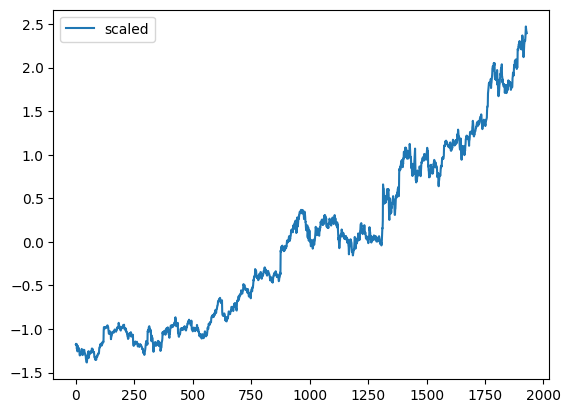

In [10]:
# Visualize scaled data
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 30 as we want our network to have memory of 30 days.

In [11]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (1900, 30, 1)
Testing input shape:  (1564, 30, 1)


In [13]:
X_train[1727]

array([[1.38820948],
       [1.40305761],
       [1.42355826],
       [1.43383119],
       [1.43418989],
       [1.44127791],
       [1.44836548],
       [1.46334845],
       [1.44666074],
       [1.36618344],
       [1.36228078],
       [1.30840507],
       [1.29427425],
       [1.31706254],
       [1.32338795],
       [1.37044507],
       [1.37084898],
       [1.3621463 ],
       [1.4024748 ],
       [1.38462066],
       [1.37044507],
       [1.35460995],
       [1.34021015],
       [1.34047922],
       [1.33428865],
       [1.33863999],
       [1.33523078],
       [1.39628414],
       [1.39471398],
       [1.40094941]])

In [14]:
# set seed to regenerate same sequence of random numbers.
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length is 30` and `num_features is 1`.

In [15]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                               

## Train Model

In [16]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
54/54 [==============================] - 11s 124ms/step - loss: 0.1041 - val_loss: 0.1854
Epoch 2/100
54/54 [==============================] - 5s 87ms/step - loss: 0.0339 - val_loss: 0.1432
Epoch 3/100
54/54 [==============================] - 5s 86ms/step - loss: 0.0232 - val_loss: 0.0821
Epoch 4/100
54/54 [==============================] - 7s 121ms/step - loss: 0.0258 - val_loss: 0.0543
Epoch 5/100
54/54 [==============================] - 4s 83ms/step - loss: 0.0290 - val_loss: 0.0521
Epoch 6/100
54/54 [==============================] - 6s 110ms/step - loss: 0.0315 - val_loss: 0.0510
Epoch 7/100
54/54 [==============================] - 4s 83ms/step - loss: 0.0258 - val_loss: 0.0406
Epoch 8/100
54/54 [==============================] - 6s 104ms/step - loss: 0.0193 - val_loss: 0.0391
Epoch 9/100
54/54 [==============================] - 5s 90ms/step - loss: 0.0175 - val_loss: 0.0424
Epoch 10/100
54/54 [==============================] - 5s 85ms/step - loss: 0.0184 - val_loss: 0

#### Plot Training - Validation loss

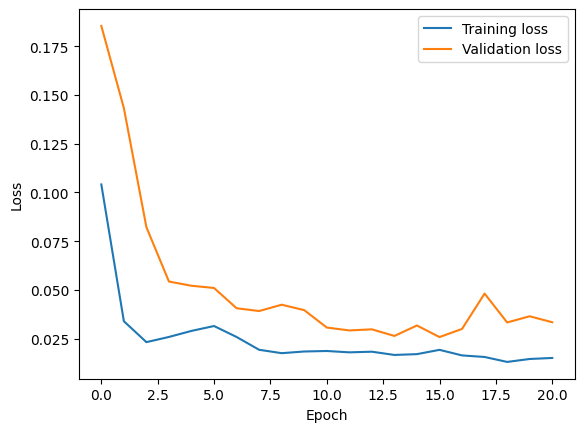

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

60/60 [==============================] - 4s 49ms/step
Reconstruction error threshold: 0.43839716694304115


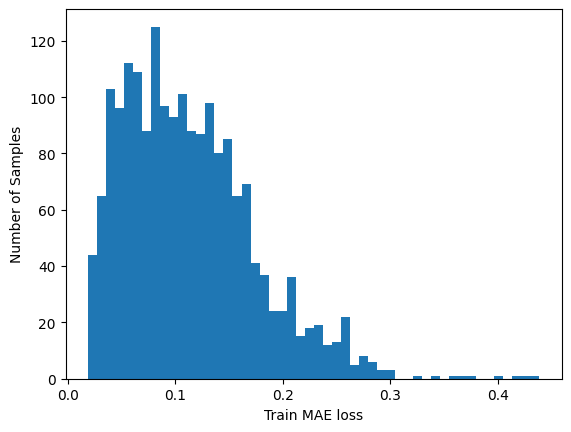

In [18]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

### Reconstruction error threshold: 0.48992275269204094

## Predict Anomalies on test data using threshold

49/49 [==============================] - 1s 29ms/step


Text(0, 0.5, 'Number of samples')

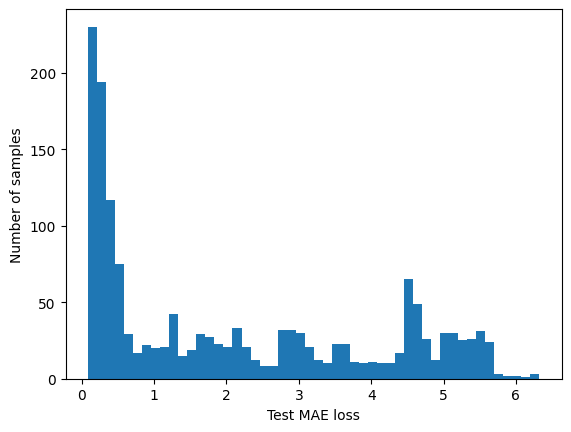

In [19]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [20]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [21]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
1960,2018-02-08,2.133545,0.305230,0.438397,False
1961,2018-02-09,2.296204,0.402113,0.438397,False
1962,2018-02-12,2.359725,0.436260,0.438397,False
1963,2018-02-13,2.360443,0.442151,0.438397,True
1964,2018-02-14,2.439395,0.443511,0.438397,True


In [22]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [23]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
1963,2018-02-13,2.360443,0.442151,0.438397,True
1964,2018-02-14,2.439395,0.443511,0.438397,True
1994,2018-03-29,2.269334,0.452364,0.438397,True
1995,2018-04-02,2.155750,0.452342,0.438397,True
1996,2018-04-03,2.186883,0.468478,0.438397,True


In [43]:
anomalies.shape

(1055, 5)

In [38]:
import numpy as np

# Assuming anomaly_df['Close'] is a pandas Series
close_prices = anomaly_df['Close'].values.reshape(-1, 1)

# Assuming scaler is a fitted scaler object
scaled_close_prices = scaler.inverse_transform(close_prices)

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=scaled_close_prices.flatten(), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close'].values.reshape(-1, 1)).flatten(), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()


F1 score, precision, recall, and ROC curve.

Precision: 0.6745524296675192
Recall: 1.0
F1 Score: 0.8056510118365788


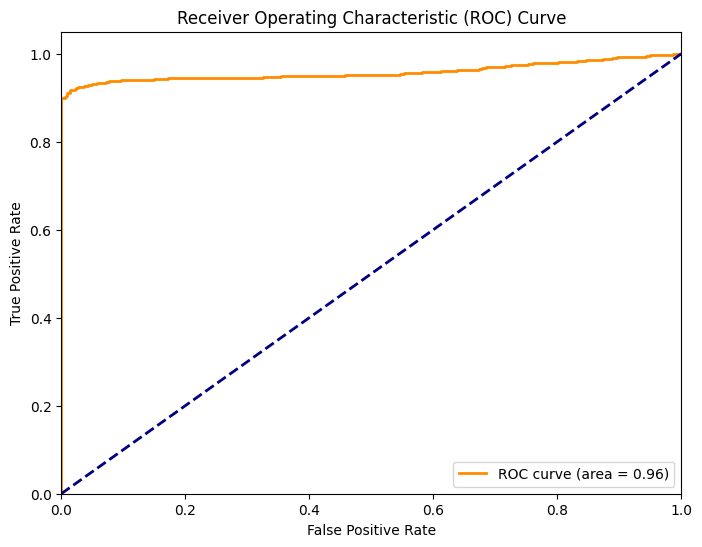

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Set a threshold for anomaly detection
threshold = 0.5  # Adjust this threshold as needed

# Convert predicted anomaly scores to binary labels based on the threshold
predicted_labels_binary = (predicted_labels > threshold).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(anomaly_df['anomaly_binary'], predicted_labels_binary)
recall = recall_score(anomaly_df['anomaly_binary'], predicted_labels_binary)
f1 = f1_score(anomaly_df['anomaly_binary'], predicted_labels_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(anomaly_df['anomaly_binary'], predicted_labels)
roc_auc = roc_auc_score(anomaly_df['anomaly_binary'], predicted_labels)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
